In [ ]:
# Download and extract the dataset for NLP with Disaster Tweets Kaggle competition
!kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip -d nlp-getting-started

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Load the datasets
og_train_df = pd.read_csv("nlp-getting-started/train.csv")
og_test_df = pd.read_csv("nlp-getting-started/test.csv")

In [3]:
og_train_df["id"].value_counts().sum()
og_test_df["id"].value_counts().sum()


3263

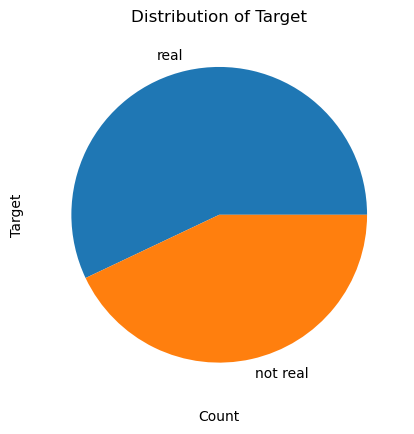

In [4]:
# train_df["target"].value_counts().plot(kind='barh', color='blue', alpha=0.7)
plt.pie(og_train_df["target"].value_counts(), labels=["real", "not real"])
plt.xlabel("Count")
plt.ylabel("Target")
plt.title("Distribution of Target")
plt.show()

## Preprocessing
Preprocess the dataset before splitting it into the 70/30 distribution required by the assignment. Although we have followed the instruction's recommendations. We took some liberties with the order and depth to which we followed the instructions. Thus, our preprocesing consists of:

1. Removing punctuation  - This is helpful in standardizing the texts, but can create some isues in multiword lexical units and names. To solve this, a name entity recognition should be applied before this step.

2. Converting all text to lower case - As with the previous point, this help in standardization. Makes the text uniform and minimizes the influence of grammatical errors or stylized text.

3. Stopword removal - Stopwords are lexical units that have no semantic meaning; they are present to satisfy the syntactic requirements of the language. Thus, they are of little to no use to us in this assignment. The list of stopwords used in this program was provided on [this website](https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt)

4. Training dataset 70/30 split - Since our test dataset does not contain the target values we aim to predict, we must use a subset of our training set for the purposes of fine-tuning the model. Another option to consider would be running a k-fold structure.


In [5]:
# Remove punctuation to allow for better word manipulation, except in hyphenation cases, an exception we're willing to make given that this is not a deep linguistic analisys. However, if we wanted to maintain the most semantic context, a name entity recognition system should parse this text beforehand.
import string

print(og_train_df['text'].head())

# Remove punctuation using translate
og_train_df["text"] = og_train_df["text"].str.translate(str.maketrans("", "", string.punctuation))
print(og_train_df['text'].head())

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object
0    Our Deeds are the Reason of this earthquake Ma...
1                Forest fire near La Ronge Sask Canada
2    All residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    Just got sent this photo from Ruby Alaska as s...
Name: text, dtype: object


In [6]:
# Convert text to lowercase
og_train_df['text'] = og_train_df['text'].str.lower()
print(og_train_df["text"].head())

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object


In [7]:
# Get the list of stopwords to be removed (stopwords list not mine)
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 

# This function takes a string and checks if each of its words is in the stopword list. If so, it removes it from the string
def remove_stopwords(text):
    if isinstance(text, str):  # Ensure the value is a string
        return " ".join([word for word in text.split() if word not in stopwords])
    return text

og_train_df['text'] = og_train_df['text'].apply(remove_stopwords)

print(og_train_df["text"].head())

0                deeds reason earthquake allah forgive
1                             forest ronge sask canada
2    residents asked shelter place notified officer...
3    13000 people receive wildfires evacuation orde...
4       photo ruby alaska smoke wildfires pours school
Name: text, dtype: object


In [3]:
# Lemmatize the remaining words
import spacy


ModuleNotFoundError: No module named 'spacy'

In [13]:
from sklearn.model_selection import train_test_split

# Split DataFrame into 70% train and 30% test
train_df, test_df = train_test_split(og_train_df, test_size=0.3, random_state=42)